  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  
  TransactionID CustomerID ProductID      TransactionDate  Quantity  

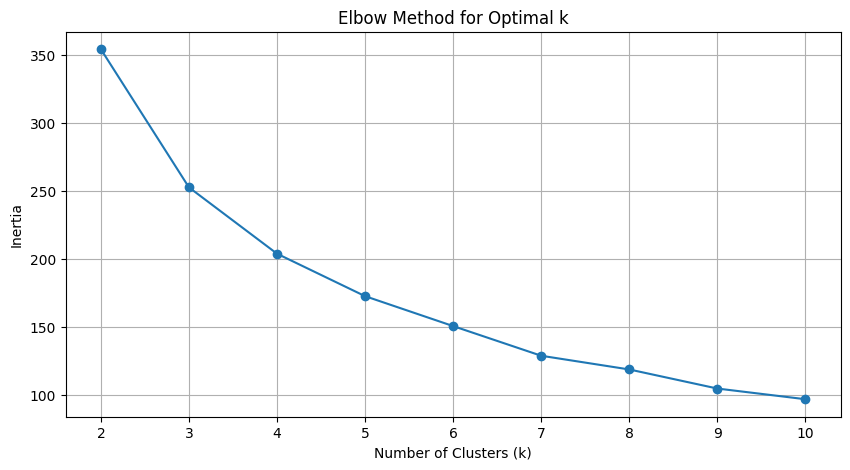

Davies-Bouldin Index: 1.0031741006145798


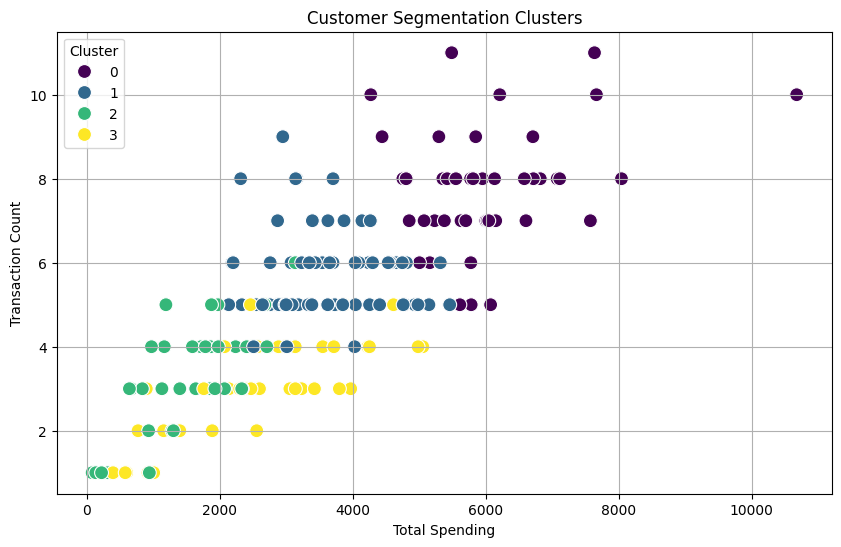

Silhouette Score: 0.3016612633219287
Calinski-Harabasz Index: 125.42435176148314
Cluster Sizes:
Cluster
1    66
2    45
0    44
3    44
Name: count, dtype: int64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows of each dataset
print(customers.head())
print(transactions.head())

# Merge datasets on CustomerID
merged_data = pd.merge(transactions, customers, on='CustomerID')

# Display the merged data
print(merged_data.head())

# Feature Engineering
customer_features = merged_data.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Number of transactions
    'TotalValue': 'sum',       # Total spending
    'Price': 'mean'            # Average transaction value
}).reset_index()

# Rename columns for clarity
customer_features.columns = ['CustomerID', 'TransactionCount', 'TotalSpending', 'AverageTransactionValue']

# Merge with customer profile data
customer_profiles = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID')

# Display the customer profiles
print(customer_profiles.head())

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles[['TransactionCount', 'TotalSpending', 'AverageTransactionValue']])

# Determine optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

# Perform K-Means clustering with the optimal number of clusters
optimal_k = 4  # Example optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate DB Index
db_index = davies_bouldin_score(scaled_features, customer_profiles['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_profiles, x='TotalSpending', y='TransactionCount', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Spending')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.grid()
plt.show()

from sklearn.metrics import silhouette_score

# Calculate Silhouette Score
silhouette_avg = silhouette_score(scaled_features, customer_profiles['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

from sklearn.metrics import calinski_harabasz_score

# Calculate Calinski-Harabasz Index
calinski_harabasz_index = calinski_harabasz_score(scaled_features, customer_profiles['Cluster'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_index}')

# Calculate cluster sizes
cluster_sizes = customer_profiles['Cluster'].value_counts()
print(f'Cluster Sizes:\n{cluster_sizes}')